<a href="https://colab.research.google.com/github/NathanLabiosa/AlzheimersSeverityClassifier/blob/main/Alzheimers'_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [ ]:
from google.colab import drive
import os
import shutil 
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

# feel free to edit this cell to work with your local or colab directory
WORKING_DIR = '/content/drive/My Drive/Colab Notebooks/Alzheimers'
TRAIN_DIR = '/content/drive/My Drive/Colab Notebooks/Alzheimers/OriginalDataset'
VAL_DIR = '/content/drive/My Drive/Colab Notebooks/Alzheimers/val'

#shutil.move(os.path.join(WORKING_DIR,'ImageData','MildDemented'), os.path.join(TRAIN_DIR))
#shutil.move(os.path.join(WORKING_DIR,'ImageData','ModerateDemented'), os.path.join(TRAIN_DIR))
#shutil.move(os.path.join(WORKING_DIR,'ImageData','NonDemented'), os.path.join(TRAIN_DIR))
#shutil.move(os.path.join(WORKING_DIR,'ImageData','VeryMildDemented'), os.path.join(TRAIN_DIR))
#os.rmdir(os.path.join(WORKING_DIR,'ImageData'))

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
from glob import glob

from sklearn.model_selection import train_test_split

mild = glob(TRAIN_DIR + '/MildDemented/*.jpg')
moderate = glob(TRAIN_DIR + '/ModerateDemented/*.jpg')
non = glob(TRAIN_DIR + '/NonDemented/*.jpg')
vmild = glob(TRAIN_DIR + '/VeryMildDemented/*.jpg')

# The *_val variables contain the filenames of the files chosen for validation. 
mild_train, mild_val = train_test_split(mild, test_size=0.3)
moderate_train, moderate_val = train_test_split(moderate, test_size=0.3)
non_train, non_val = train_test_split(non, test_size=0.3)
vmild_train, vmild_val = train_test_split(vmild, test_size=0.3)


# This code moves the validation files out of the train directory and over to 
# the val directory.
os.makedirs(os.path.join(VAL_DIR,'MildDemented'), exist_ok=True)
for file in mild_val:
  os.rename(file, file.replace('train','val'))

os.makedirs(os.path.join(VAL_DIR,'ModerateDemented'), exist_ok=True)
for file in moderate_val:
  os.rename(file, file.replace('train','val'))

os.makedirs(os.path.join(VAL_DIR,'NonDemented'), exist_ok=True)
for file in non_val:
  os.rename(file, file.replace('train','val'))

os.makedirs(os.path.join(VAL_DIR,'VeryMildDemented'), exist_ok=True)
for file in vmild_val:
  os.rename(file, file.replace('train','val'))

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet_v2 import preprocess_input

WIDTH = 299
HEIGHT = 299
BATCH_SIZE = 11

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    zoom_range=[1,2],
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    zoom_range=[1,2],
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
		class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(HEIGHT, WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 6204 images belonging to 4 classes.
Found 286 images belonging to 4 classes.


In [ ]:
from tensorflow import keras
from keras.models import Model

from tensorflow.keras.applications.resnet_v2 import ResNet152V2

base_model = ResNet152V2(weights='imagenet', include_top=False)

234561536/234545216 [==============================] - 1s 0us/step


In [ ]:
from keras.layers import Dense, GlobalAveragePooling2D, Dropout


CLASSES = 4
# These layers were removed by setting include_top=false, but we still want them
x = base_model.output                          # The output layer of the googleNet
x = GlobalAveragePooling2D(name='avg_pool')(x) # This layer is used to downsample the features
x = Dropout(0.4)(x)                            # This layer is used to enforce feature redundancy 

# This layer specifies our classifier output
predictions = Dense(CLASSES, activation='softmax')(x)
#
model = Model(inputs=base_model.input, outputs=predictions)



In [ ]:
for layer in base_model.layers:
    layer.trainable = False # Set this to True if you want to re-train the entire network.

In [ ]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
EPOCHS = 15
BATCH_SIZE = 11
STEPS_PER_EPOCH = 5
VALIDATION_STEPS = 1
MODEL_FILE = os.path.join(WORKING_DIR,'model_ex')

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Epoch 1/15
5/5 [==============================] - 87s 17s/step - loss: 1.7961 - accuracy: 0.3818 - val_loss: 1.4291 - val_accuracy: 0.5455
Epoch 2/15
5/5 [==============================] - 54s 11s/step - loss: 1.2269 - accuracy: 0.5636 - val_loss: 1.3053 - val_accuracy: 0.1818
Epoch 3/15
5/5 [==============================] - 54s 11s/step - loss: 1.2057 - accuracy: 0.4364 - val_loss: 1.5121 - val_accuracy: 0.3636
Epoch 4/15
5/5 [==============================] - 58s 12s/step - loss: 1.2775 - accuracy: 0.4545 - val_loss: 1.5986 - val_accuracy: 0.2727
Epoch 5/15
5/5 [==============================] - 54s 11s/step - loss: 1.2056 - accuracy: 0.4364 - val_loss: 1.3431 - val_accuracy: 0.1818
Epoch 6/15
5/5 [==============================] - 54s 11s/step - loss: 1.3711 - accuracy: 0.3636 - val_loss: 1.2299 - val_accuracy: 0.3636
Epoch 7/15
5/5 [==============================] - 54s 11s/step - loss: 1.3296 - accuracy: 0.4909 - val_loss: 2.0215 - val_accuracy: 0.2727
Epoch 8/15
5/5 [===========

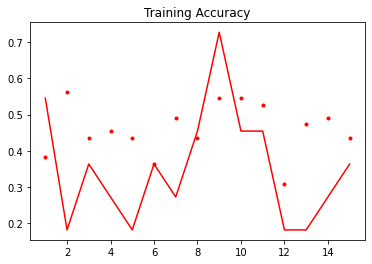

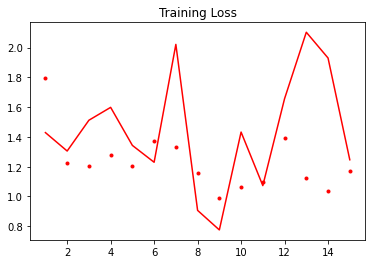

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

plt.plot(epochs, val_acc,'r')
plt.plot(epochs, acc,'r.')
plt.title("Training Accuracy")

plt.figure()
plt.plot(epochs, val_loss,'r')
plt.plot(epochs,loss,'r.')
plt.title("Training Loss")
plt.show()

In [ ]:
print('Validation Accuracy at Final Epoch =', val_acc[-1])
print(val_acc)

Validation Accuracy at Final Epoch = 0.3636363744735718
[0.5454545617103577, 0.1818181872367859, 0.3636363744735718, 0.27272728085517883, 0.1818181872367859, 0.3636363744735718, 0.27272728085517883, 0.4545454680919647, 0.7272727489471436, 0.4545454680919647, 0.4545454680919647, 0.1818181872367859, 0.1818181872367859, 0.27272728085517883, 0.3636363744735718]


Mounted at /content/drive


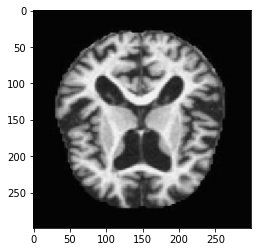

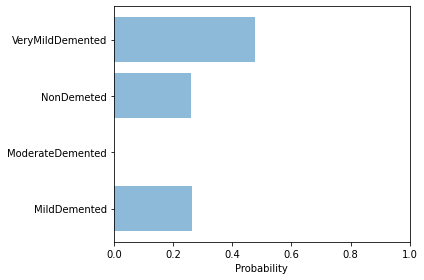

In [ ]:
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

# Predict pre-processes the input so that it matches the format expected by the 
# network, then runs model.predict which provides the class predictions
def predict(model, img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]

# We plot the original image
plt.figure()
img = image.load_img('/content/drive/My Drive/Colab Notebooks/Alzheimers/test/ModeratelyDemented1.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(load_model(MODEL_FILE), img)
plt.imshow(img)

# We can visualize the predicted likelihood of each class
plt.figure()
labels = ["MildDemented", "ModerateDemented","NonDemeted","VeryMildDemented"]
plt.barh(range(4),preds,alpha=0.5)
plt.yticks(range(4),labels)
plt.xlabel('Probability')
plt.xlim(0,1)
plt.tight_layout()
plt.show()

Mounted at /content/drive


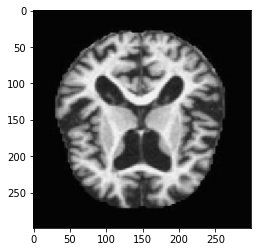

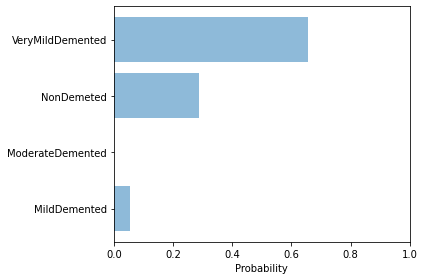

In [ ]:
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
drive.flush_and_unmount()
drive.mount('/content/drive', force_remount=True)

# Predict pre-processes the input so that it matches the format expected by the 
# network, then runs model.predict which provides the class predictions
def predict(model, img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]

# We plot the original image
plt.figure()
img = image.load_img('/content/drive/My Drive/Colab Notebooks/Alzheimers/test/ModeratelyDemented1.jpg', target_size=(HEIGHT, WIDTH))
preds = predict(load_model(MODEL_FILE), img)
plt.imshow(img)

# We can visualize the predicted likelihood of each class
plt.figure()
labels = ["MildDemented", "ModerateDemented","NonDemeted","VeryMildDemented"]
plt.barh(range(4),preds,alpha=0.5)
plt.yticks(range(4),labels)
plt.xlabel('Probability')
plt.xlim(0,1)
plt.tight_layout()
plt.show()